# Experiment - 1.0

Having reasonably understood what CNNs are, why they are used for image data and how they work, it is finally time to start with the task.
In this experiment I hope to create a dataset and train a neural classifier on it.

***IMPORTANT:*** At the time this experiment was conducted, I was following the naming convention of the [learnpytorch.io](https://learnpytorch.io) course which refers to the `validation` data and step as `test` data and step respectively. The model is run on the `test` set after each epoch to check the generalisation ability after each epoch.


## Getting the Fonts

To start, I upload the fonts I'm gonna use for the hard set.

In [38]:
# from google.colab import files
# import os
# import shutil
# uploaded = files.upload()
# os.makedirs("/content/fonts", exist_ok=True)
# for filename in uploaded.keys():
#     shutil.move(filename, "/content/fonts")

# Uncomment if using Google Colab

## Data Generator

ChatGPT assisted me in writing the following code to synthesize my own dataset.
The raw data consists of .png CAPTCHAs each 60 pixels in height and 180 pixels in width with 3 channels (RGB).

Here I choose to artificially increase the size of the base data by augmenting it randomly. Without any augmentation, the easy set would be limited to one image per class(word). I plan to first train a model only on the easy set, to test and thus require more than one image per class. Thus even in the easy set, each sample is randomly shifted or rotated a bit. Without augmentation, the model would be grossly overfit.

The generate_dataset() function takes two parameters:
**num_easy**: The number of samples per class in the easy set.
**num_hard**: The number of samples per class in the hard set.

In [ ]:
import os
import shutil
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageOps

# Macros
WORDS = [
    "Ainz", "Momonga", "Demiurge", "albedo", "Cocytus", "aura", "mare", "Sebastian", "victim", "Gargantua", "Pandora", "Actor", "shall", "tear", "blood", "fallen", "Ooal", "gown"
]
FONTS_EASY=["../data/fonts/arial.TTF"]
FONTS_HARD = ["../data/fonts/arial.TTF", "../data/fonts/Inkfree.TTF", "../data/fonts/BRITANIC.TTF", "../data/fonts/times.ttf", "../data/fonts/comic.ttf"]
OUTPUT_DIR = "../data/dataset"

IMAGE_SIZE = (180, 60)  # Width, Height
TRAIN_SPLIT = 0.8  # 80% train, 20% test

# Helper Functions

def apply_noise(image, mode='gaussian'):
    """Apply Gaussian or salt-and-pepper noise."""
    im_arr = np.asarray(image).astype(np.float32)

    if mode == 'gaussian':
        mean = 0
        std = 32
        noise = np.random.normal(mean, std, im_arr.shape)
        im_arr = im_arr + noise
    elif mode == 'sp':
        prob = 0.032
        salt_prob = prob / 2
        pepper_prob = prob / 2
        random_matrix = np.random.rand(*im_arr.shape[:2])
        im_arr[random_matrix < salt_prob] = 255
        im_arr[random_matrix > 1 - pepper_prob] = 0

    im_arr = np.clip(im_arr, 0, 255).astype(np.uint8)
    return Image.fromarray(im_arr)

def random_capitalization(word):
    return "".join([char.upper() if random.random() > 0.6 else char.lower() for char in word])

def random_text_color():
    return tuple(np.random.randint(0, 128, size=3))

def apply_augmentation(image):
    angle = random.uniform(-5, 5)
    image = image.rotate(angle, expand=False, fillcolor="white")

    x_shift = random.randint(-5, 5)
    y_shift = random.randint(-5, 5)
    image = ImageOps.expand(image, border=(abs(x_shift), abs(y_shift)), fill="white")
    image = image.transform(
        IMAGE_SIZE,
        Image.AFFINE,
        (1, 0, -x_shift, 0, 1, -y_shift),
        fillcolor="white"
    )

    return image

def generate_captcha(word, font_path, output_dir, is_hard=False, augment=False):
    """Generate a single CAPTCHA image."""
    image = Image.new("RGB", IMAGE_SIZE, color="white")
    draw = ImageDraw.Draw(image)

    font_size = 28
    font = ImageFont.truetype(font_path, font_size)

    text_color = "black"
    if is_hard:
        word = random_capitalization(word)
        text_color = random_text_color()

    text_bbox = draw.textbbox((0, 0), word, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    x = (IMAGE_SIZE[0] - text_width) / 2
    y = (IMAGE_SIZE[1] - text_height) / 4
    draw.text((x, y), word, fill=text_color, font=font)

    if augment:
      image = apply_augmentation(image)

    if is_hard:
        if random.random() > 0.5:
            image = apply_noise(image, mode='gaussian')
        else:
            image = apply_noise(image, mode='sp')


    filename = f"{word}_{hash(word + str(random.random()))}.png"
    image.save(os.path.join(output_dir, filename))
    return filename


# Generate Dataset
def generate_dataset(num_easy=1, num_hard=3, augment=False):
    # Set up directories
    base_dirs = {
        "easy_train": os.path.join(OUTPUT_DIR, "easy", "train"),
        "easy_test": os.path.join(OUTPUT_DIR, "easy", "test"),
        "hard_train": os.path.join(OUTPUT_DIR, "hard", "train"),
        "hard_test": os.path.join(OUTPUT_DIR, "hard", "test")
    }
    for base_dir in base_dirs.values():
        if os.path.exists(base_dir):
            shutil.rmtree(base_dir)
        os.makedirs(base_dir, exist_ok=True)

    # Generate Easy and Hard Set
    for word in WORDS:
        # Easy Set
        easy_samples = [generate_captcha(word, random.choice(FONTS_EASY), OUTPUT_DIR, is_hard=False, augment=augment) for _ in range(num_easy)]
        easy_train = easy_samples[:int(TRAIN_SPLIT * num_easy)]
        easy_test = easy_samples[int(TRAIN_SPLIT * num_easy):]

        for img_path in easy_train:
            target_dir = os.path.join(base_dirs["easy_train"], word)
            os.makedirs(target_dir, exist_ok=True)
            shutil.move(os.path.join(OUTPUT_DIR,img_path), target_dir)
        for img_path in easy_test:
            target_dir = os.path.join(base_dirs["easy_test"], word)
            os.makedirs(target_dir, exist_ok=True)
            shutil.move(os.path.join(OUTPUT_DIR,img_path), target_dir)

        # Hard Set
        hard_samples = [generate_captcha(word, random.choice(FONTS_HARD), OUTPUT_DIR, is_hard=True, augment=augment) for _ in range(num_hard)]
        hard_train = hard_samples[:int(TRAIN_SPLIT * num_hard)]
        hard_test = hard_samples[int(TRAIN_SPLIT * num_hard):]

        for img_path in hard_train:
            target_dir = os.path.join(base_dirs["hard_train"], word)
            os.makedirs(target_dir, exist_ok=True)
            shutil.move(os.path.join(OUTPUT_DIR,img_path), target_dir)
        for img_path in hard_test:
            target_dir = os.path.join(base_dirs["hard_test"], word)
            os.makedirs(target_dir, exist_ok=True)
            shutil.move(os.path.join(OUTPUT_DIR,img_path), target_dir)

generate_dataset(5, 10, False)


Note that samples belonging to same class are placed in a folder with same name as their class.
If I am not mistaken, this is the standard image classification format and allows us to use the class[`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder) to turn the raw data into a `Dataset` capable of being used with PyTorch.

Not only does this streamline the process of loading the images into a `Dataset`, it also allows easy identifcation of true labels of the samples thereby eliminating the need to separately maintain a file that maps labels to samples.

Note that for this first experiment a dataset of only 10 classes is generated. Run the function with the following parameters to get 10 easy and 30 hard samples per class.

In [3]:
generate_dataset(10, 30, True)

In [43]:
shutil.make_archive("captcha_data", 'zip', OUTPUT_DIR)
# files.download("captcha_data.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Next I set up the code to be [device-agnostic](https://pytorch.org/docs/stable/notes/cuda.html#best-practices) which allows me to seamlessly switch the runtime type (cpu - gpu)

In [2]:
# Setup device-agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [1]:
# Import necessary libraries for training CNNs in PyTorch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

## Visualising the Dataset

Before I can begin deciding on the architecture and hyperparameters, I should visualise the form/structure of the generated dataset. Let's start with getting familiar with the directory structure.

In [6]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [40]:
walk_through_dir(OUTPUT_DIR)

There are 2 directories and 0 images in '/kaggle/working/fontset/data'.
There are 2 directories and 0 images in '/kaggle/working/fontset/data/hard'.
There are 20 directories and 0 images in '/kaggle/working/fontset/data/hard/train'.
There are 0 directories and 160 images in '/kaggle/working/fontset/data/hard/train/learning'.
There are 0 directories and 160 images in '/kaggle/working/fontset/data/hard/train/perhaps'.
There are 0 directories and 160 images in '/kaggle/working/fontset/data/hard/train/Byzantine'.
There are 0 directories and 160 images in '/kaggle/working/fontset/data/hard/train/black'.
There are 0 directories and 160 images in '/kaggle/working/fontset/data/hard/train/banana'.
There are 0 directories and 160 images in '/kaggle/working/fontset/data/hard/train/titan'.
There are 0 directories and 160 images in '/kaggle/working/fontset/data/hard/train/slayer'.
There are 0 directories and 160 images in '/kaggle/working/fontset/data/hard/train/apple'.
There are 0 directories and 

So, we have the following four directories that follow the standard image classification format:

In [8]:
easy_train_dir = os.path.join(OUTPUT_DIR, 'easy', 'train')
easy_test_dir = os.path.join(OUTPUT_DIR, 'easy', 'test')
hard_train_dir = os.path.join(OUTPUT_DIR, 'hard', 'train')
hard_test_dir = os.path.join(OUTPUT_DIR, 'hard', 'test')

Now Let's visualize one of the actual images generated using PIL.

Random image path: /kaggle/working/fontset/data/hard/test/shadow/sHadow_6810474595056391741.png
Image class: shadow
Image height: 60
Image width: 180


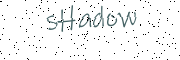

In [9]:

from pathlib import Path

img_path = Path(OUTPUT_DIR)

random.seed(11043025) # A new random image for every seed

# Get all image paths
image_path_list = list(img_path.glob("*/*/*/*.png"))

# Choose one image
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

That looks like a good enough sample to me. 

## Loading the dataset

First create a `PyTorch` compatible dataset that contains img data in the form of tensors and not arrays.

In [10]:
from torch.utils.data import ConcatDataset
easy_train_data, easy_test_data, hard_train_data, hard_test_data, combined_train_data, combined_test_data = None, None, None, None, None, None
class_names = None
def create_datasets():
  global easy_train_data, easy_test_data, hard_train_data, hard_test_data, class_names, combined_train_data, combined_test_data
  easy_train_data = datasets.ImageFolder(root=easy_train_dir, # target folder of images
                                  transform=transforms.ToTensor(), # transforms to perform on data (images)
                                  target_transform=None)

  easy_test_data = datasets.ImageFolder(root=easy_test_dir,
                                 transform=transforms.ToTensor())

  hard_train_data = datasets.ImageFolder(root=hard_train_dir, # target folder of images
                                  transform=transforms.ToTensor(), # transforms to perform on data (images)
                                  target_transform=None)

  hard_test_data = datasets.ImageFolder(root=hard_test_dir,
                                 transform=transforms.ToTensor())
  class_names= easy_train_data.classes

  combined_train_data = ConcatDataset([easy_train_data, hard_train_data])
  combined_test_data = ConcatDataset([easy_test_data, hard_test_data])

  print(f"Easy Train data:\n{easy_train_data}\nEasy Test data:\n{easy_test_data}\nHard Train data:\n{hard_train_data}\nHard Test data:\n{hard_test_data}")
  print(f"Combined Train data:\n{combined_train_data}\nCombined Test data:\n{combined_test_data}")


In [11]:
create_datasets()


Easy Train data:
Dataset ImageFolder
    Number of datapoints: 80
    Root location: /kaggle/working/fontset/data/easy/train
    StandardTransform
Transform: ToTensor()
Easy Test data:
Dataset ImageFolder
    Number of datapoints: 20
    Root location: /kaggle/working/fontset/data/easy/test
    StandardTransform
Transform: ToTensor()
Hard Train data:
Dataset ImageFolder
    Number of datapoints: 240
    Root location: /kaggle/working/fontset/data/hard/train
    StandardTransform
Transform: ToTensor()
Hard Test data:
Dataset ImageFolder
    Number of datapoints: 60
    Root location: /kaggle/working/fontset/data/hard/test
    StandardTransform
Transform: ToTensor()
Combined Train data:
Combined Test data:


Wonderful! ImageFolder did all the work for me!
Now to check if the intended labels carried over...

In [12]:
# get class names
class_dict = easy_train_data.class_to_idx
class_names, class_dict

(['apple',
  'banana',
  'machine',
  'perhaps',
  'restaurant',
  'shadow',
  'slayer',
  'tiger',
  'titan',
  'verdant'],
 {'apple': 0,
  'banana': 1,
  'machine': 2,
  'perhaps': 3,
  'restaurant': 4,
  'shadow': 5,
  'slayer': 6,
  'tiger': 7,
  'titan': 8,
  'verdant': 9})

Let me also check the shape of a random img tensor. This will help me choose/design the architecture of the CNN:

In [13]:
img, label = easy_train_data[30][0], easy_train_data[30][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
Image shape: torch.Size([3, 60, 180])
Image datatype: torch.float32
Image label: 3
Label datatype: <class 'int'>


I notice that the images are in the form of a tensor with shape `[3, 60, 180]` in order `CHW` (channels-height-width). I can visualize an individual image using `matplotlib`. I permute the dimensions since only the `CHW` is not compatible with matplotlib. Instead I require an image of dimension `HWC`:

Original shape: torch.Size([3, 60, 180]) -> [color_channels, height, width]
Image permute shape: torch.Size([60, 180, 3]) -> [height, width, color_channels]


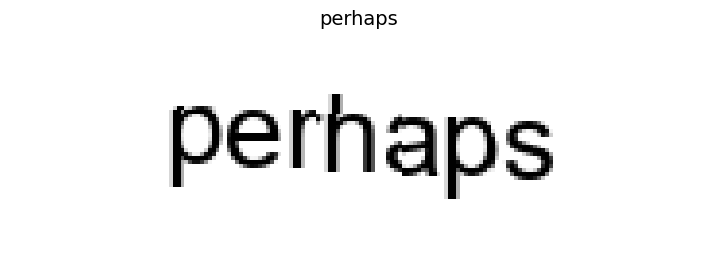

In [14]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(9, 6))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### Creating the DataLoader

Now that I the form of the dataset is clear to me, I can turn the datasets into `Dataloaders` that makes the data iterable (for training the model). I choose an arbitrary batch size of 32 since multiples of 2 seems to be the convention.

In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
easy_train_dataloader, easy_test_dataloader, hard_train_dataloader, hard_test_dataloader, test_dataloader, train_dataloader = None, None, None, None, None, None

def create_dataloader():
  global easy_train_dataloader, easy_test_dataloader, hard_train_dataloader, hard_test_dataloader, train_dataloader, test_dataloader
  easy_train_dataloader = DataLoader(dataset=easy_train_data,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS,
                                shuffle=True) # shuffle the test data so that optimization for all classes is distributed

  easy_test_dataloader = DataLoader(dataset=easy_test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

  hard_train_dataloader = DataLoader(dataset=hard_train_data,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS,
                                shuffle=True)

  hard_test_dataloader = DataLoader(dataset=hard_test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False) # don't need to shuffle testing data

  train_dataloader = DataLoader(dataset=combined_train_data,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS,
                                shuffle=True)

  test_dataloader = DataLoader(dataset=combined_test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

  print(f"Easy Train dataloader:\n{easy_train_dataloader}\nEasy Test dataloader:\n{easy_test_dataloader}\nHard Train dataloader:\n{hard_train_dataloader}\nHard Test dataloader:\n{hard_test_dataloader}")
  print(f"Train dataloader:\n{train_dataloader}\nTest dataloader:\n{test_dataloader}")
# create_dataloader()

In [16]:
create_dataloader()

Easy Train dataloader:
Easy Test dataloader:
Hard Train dataloader:
Hard Test dataloader:
Train dataloader:
Test dataloader:


Nice! Now I have separate `Dataloader`s for each of my 4 datasets: easy(train + test) and hard(train + test).

## Defining the Model

The following is the initial architecture for the Neural Classifier that I have decided to go with. I decided to go with three 2D Convolutional layers as that seemed like a reasonable number that seems to be sufficient for the task of classifying CAPTCHAS as gathered from several blog posts and papers. (A few of the sources I read complicated it with upwards of 6-7 layers but I find that to be unreasonable for the scope of this task).

The justification behind the choice of layers is as follows:

1. **Three layers of convolution:**

Each layer of the convolution gets progressively deeper (16 -> 32 -> 64 filters) and thereby extract low -> mid -> high level features of the text in order.
i. 1st Conv extracts basic edges, lines and curves.
ii. 2nd Conv recogizes letter shapes.
iii. 3rd Conv captures the higher-order patterns and structures.

2. **Choice of Kernel, Activation and Pooling:**

Not having much experience in CNNs apriori, much of my intial design is inspired from the two primary sources I used for learning: [learnpytorch.io](https://learnpytorch.io) and [CNN Explainer](https://poloclub.github.io/cnn-explainer). In particular A kernel size of 3, stride of 1 and padding of 1 for all conv layers was chosen inspired by the TinyVGG (VGG) neural architecture (different use case, but it seemed to work). The conv layers are individually followed by an activation layer using ReLU as the activation function to introduce non-linearity as well as a Max-pooling layer (2*2) to compress the data whilst preserving the feature mappings.

3. **Classification:**

Finally, the obtained feature mappings are flattened into a 1D vector (7\*22\*64 -> 9856 features)and fed into a fully connected layer of 128 neurons that classify the image into one of 10 final classes.



In [17]:
class Classifier(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),  # Output: 60x180x16
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2),  # Output: 30x90x16

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units*2,
                  kernel_size=3,
                  stride=1,
                  padding=1),  # Output: 30x90x32
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2),  # Output: 15x45x32

        nn.Conv2d(in_channels=hidden_units*2,
                  out_channels=hidden_units*4,
                  kernel_size=3,
                  stride=1,
                  padding=1),  # Output: 15x45x64
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2)  # Output: 7x22x64
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),  # Flatten to 7*22*64
        nn.Linear(7*22*hidden_units*4, hidden_units*8), # Fully connected layer of 128 neurons.
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_units*8, output_shape)  # 10 classes
    )

  def forward(self, x):
      return self.classifier(self.conv_layers(x))

torch.manual_seed(42)
model_0 = Classifier(input_shape=3,
                     hidden_units=16,
                     output_shape=10).to(device)
model_0


Classifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9856, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

To better visualize the model, let me use summary from torchinfo library. This also gives me an idea of the size of the present model.

In [18]:
# Install/import torchinfo
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 60, 180]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 7, 22]            --
│    └─Conv2d: 2-1                       [1, 16, 60, 180]          448
│    └─ReLU: 2-2                         [1, 16, 60, 180]          --
│    └─MaxPool2d: 2-3                    [1, 16, 30, 90]           --
│    └─Conv2d: 2-4                       [1, 32, 30, 90]           4,640
│    └─ReLU: 2-5                         [1, 32, 30, 90]           --
│    └─MaxPool2d: 2-6                    [1, 32, 15, 45]           --
│    └─Conv2d: 2-7                       [1, 64, 15, 45]           18,496
│    └─ReLU: 2-8                         [1, 64, 15, 45]           --
│    └─MaxPool2d: 2-9                    [1, 64, 7, 22]            --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Flatten: 2-10                     [1, 9856]                 --
│    └─

I run a prediction on a single image to check the output format.  I use the softmax function (used for multi-class classification) to convert the logits into probabilities and argmax to pick out the label with the highest prediction probability.

In [19]:
# Select a single image
img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# Print out model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 60, 180])

Output logits:
tensor([[ 0.0043,  0.0350, -0.0585,  0.0443,  0.0710,  0.0744,  0.0143,  0.0282,
         -0.0760, -0.0440]], device='cuda:0')

Output prediction probabilities:
tensor([[0.0994, 0.1025, 0.0933, 0.1034, 0.1062, 0.1066, 0.1004, 0.1018, 0.0917,
         0.0947]], device='cuda:0')

Output prediction label:
tensor([5], device='cuda:0')

Actual label:
0


### Creating the training loop

As expected the prediction is completely random since we have yet to train the model. Time to setup the train-test loop, starting with defining the train_step and test_step functions individually:

In [20]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    displayed_first = False

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # if not displayed_first:
        #     # Take the first image of the batch
        #     first_img_tensor = X[0].cpu()  # shape: (C, H, W)

        #     # If grayscale (1 channel), squeeze to remove channel dimension for imshow
        #     if first_img_tensor.shape[0] == 1:
        #         first_img_np = first_img_tensor.squeeze(0).numpy()
        #         cmap = 'gray'
        #     else:
        #         # Permute to (H, W, C) for color images
        #         first_img_np = first_img_tensor.permute(1, 2, 0).numpy()
        #         cmap = None

        #     # Get predicted and actual labels for the first image
        #     pred_label = y_pred_class[0].item()
        #     actual_label = y[0].item()

        #     # If you have a list of class names, you can display those:
        #     # pred_label_name = class_names[pred_label]
        #     # actual_label_name = class_names[actual_label]

        #     plt.figure(figsize=(4,4))
            # plt.imshow(first_img_np, cmap=cmap)
            # plt.title(f'Predicted: {pred_label} vs Actual: {actual_label}')
            # plt.axis('off')
            # plt.show()

            # displayed_first = True


    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [21]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Finally we have the `train()` function that calls `train_step()` and `test_step()` whilst tracking progress and storing results for plotting:

In [22]:
from tqdm.auto import tqdm

# Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # Return the filled results at the end of the epochs
    return results

## Training

It's time to finally train an instance of the `Classifier` on my dataset. First, I recreate an instance of the model:

In [23]:
# Set random seeds
torch.manual_seed(69)
torch.cuda.manual_seed(69)

# Recreate an instance of the model
model_0 = Classifier(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=16,
                  output_shape=10).to(device)



As for an **optimizer** and **loss function**, I'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of `0.01` respectively.

(Adam and SGD are the only optimizers I know of at present, hence the choice. Supposedly, using the Adam optimizer makes better use of `momentum`, speeding up model training. I need to be careful to not overfit whilst using Adam)

Given the small size of the Dataset, I train the model for 50 epochs and see where that gets me.

In [24]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=hard_train_dataloader,
                        test_dataloader=hard_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=50)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3177 | train_acc: 0.0898 | test_loss: 2.3031 | test_acc: 0.0938
Epoch: 2 | train_loss: 2.3034 | train_acc: 0.1055 | test_loss: 2.3030 | test_acc: 0.0938
Epoch: 3 | train_loss: 2.3033 | train_acc: 0.0977 | test_loss: 2.3027 | test_acc: 0.1071
Epoch: 4 | train_loss: 2.3031 | train_acc: 0.1133 | test_loss: 2.3020 | test_acc: 0.1071
Epoch: 5 | train_loss: 2.3016 | train_acc: 0.0898 | test_loss: 2.2997 | test_acc: 0.1071
Epoch: 6 | train_loss: 2.2962 | train_acc: 0.1016 | test_loss: 2.2897 | test_acc: 0.1027
Epoch: 7 | train_loss: 2.2589 | train_acc: 0.1133 | test_loss: 2.2101 | test_acc: 0.2098
Epoch: 8 | train_loss: 2.1647 | train_acc: 0.1836 | test_loss: 2.0724 | test_acc: 0.2478
Epoch: 9 | train_loss: 1.9544 | train_acc: 0.3281 | test_loss: 1.8066 | test_acc: 0.3527
Epoch: 10 | train_loss: 1.6813 | train_acc: 0.3555 | test_loss: 1.6467 | test_acc: 0.3795
Epoch: 11 | train_loss: 1.5715 | train_acc: 0.3867 | test_loss: 1.5593 | test_acc: 0.3772
Epoch: 12 | train_l

As expected with such a limited dataset, the model overfits. It can classify the training data accurately but rather than learning the general features of the class, it has instead memorized the features of the training set. This led to poor performance on the test set.

## Evaluation

Time to visualise and analyse the performance of the model.
The following function returns the result of predictions on a list of samples.

In [25]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

Here I take 36 random samples from the test data and compare the predicted class to the true class:

In [26]:
import random
def test_random_samples(model: torch.nn.Module, full: bool, test: bool):
  test_samples = []
  test_labels = []
  if full:
    if test:
      data_to_test = combined_test_data
    else:
      data_to_test = combined_train_data
  else:
    if test:
      data_to_test = easy_test_data
    else:
      data_to_test = easy_train_data
  for sample, label in random.sample(list(data_to_test), k=36):
      test_samples.append(sample)
      test_labels.append(label)

  pred_probs= make_predictions(model=model,
                              data=test_samples)
  pred_classes = pred_probs.argmax(dim=1)

  plt.figure(figsize=(9, 9))
  nrows = 12
  ncols = 3
  for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze().permute(1, 2, 0), cmap="gray")

    # Find the prediction label (in text form, e.g. "apple")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form, e.g. "restaurant")
    truth_label = class_names[test_labels[i]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);


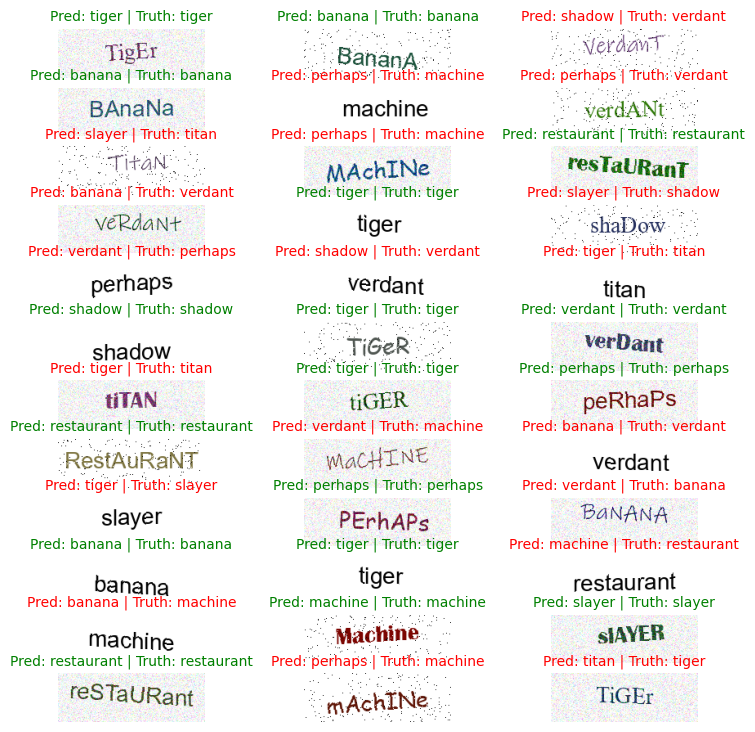

In [27]:
test_random_samples(model_0, True, True)

I can also plot the results (train and test loss and accuracy) obtained while training the model to better understand what changes I should make to the data and hyperparameters.

In [28]:
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary.
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

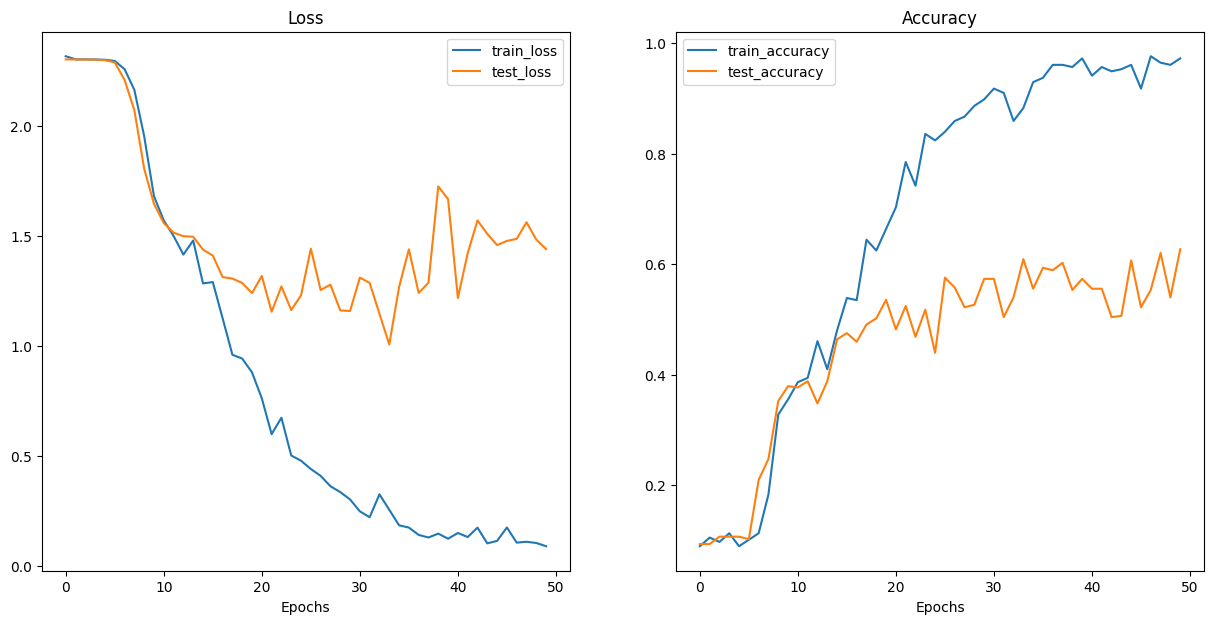

In [29]:
plot_loss_curves(model_0_results)

# Experiment - 1.1

Now that the basic pre-processing, training and evaluation pipeline is setup, it's time to train a better model. I start by expanding the dataset to a greater number of samples per class so as to improve the generalisation ability of the model. Further, I increase the number of classes to 20, before I can finally reach the target of 100.

In [30]:
WORDS = ["apple", "banana", "slayer", "perhaps", "restaurant", "tiger", "verdant", "machine", "titan", "shadow",
         "learning", "Gaming", "Explicit", "Krishak", "Byzantine", "Greek", "obey", "attitude", "yellow", "black"]

generate_dataset(50, 200, True)

create_datasets()

create_dataloader()

torch.manual_seed(69)
torch.cuda.manual_seed(69)

# Recreate an instance of the model
model_1 = Classifier(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=16,
                  output_shape=20).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_1 on easy set
model_1_results = train(model=model_1,
                        train_dataloader=easy_train_dataloader,
                        test_dataloader=easy_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=14)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")



Easy Train data:
Dataset ImageFolder
    Number of datapoints: 800
    Root location: /kaggle/working/fontset/data/easy/train
    StandardTransform
Transform: ToTensor()
Easy Test data:
Dataset ImageFolder
    Number of datapoints: 200
    Root location: /kaggle/working/fontset/data/easy/test
    StandardTransform
Transform: ToTensor()
Hard Train data:
Dataset ImageFolder
    Number of datapoints: 3200
    Root location: /kaggle/working/fontset/data/hard/train
    StandardTransform
Transform: ToTensor()
Hard Test data:
Dataset ImageFolder
    Number of datapoints: 800
    Root location: /kaggle/working/fontset/data/hard/test
    StandardTransform
Transform: ToTensor()
Combined Train data:
Combined Test data:
Easy Train dataloader:
Easy Test dataloader:
Hard Train dataloader:
Hard Test dataloader:
Train dataloader:
Test dataloader:


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9913 | train_acc: 0.0825 | test_loss: 2.9107 | test_acc: 0.1652
Epoch: 2 | train_loss: 2.5797 | train_acc: 0.1638 | test_loss: 2.1161 | test_acc: 0.4062
Epoch: 3 | train_loss: 1.8391 | train_acc: 0.3912 | test_loss: 0.9692 | test_acc: 0.7455
Epoch: 4 | train_loss: 1.2115 | train_acc: 0.5875 | test_loss: 0.4256 | test_acc: 0.9241
Epoch: 5 | train_loss: 0.7145 | train_acc: 0.7450 | test_loss: 0.2104 | test_acc: 0.9688
Epoch: 6 | train_loss: 0.5343 | train_acc: 0.7975 | test_loss: 0.1191 | test_acc: 0.9732
Epoch: 7 | train_loss: 0.3758 | train_acc: 0.8688 | test_loss: 0.0884 | test_acc: 0.9866
Epoch: 8 | train_loss: 0.2889 | train_acc: 0.8962 | test_loss: 0.0636 | test_acc: 0.9911
Epoch: 9 | train_loss: 0.1964 | train_acc: 0.9287 | test_loss: 0.0350 | test_acc: 0.9866
Epoch: 10 | train_loss: 0.1860 | train_acc: 0.9363 | test_loss: 0.0456 | test_acc: 0.9866
Epoch: 11 | train_loss: 0.1950 | train_acc: 0.9287 | test_loss: 0.0238 | test_acc: 0.9911
Epoch: 12 | train_l

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
start_time = timer()

# Train model_1 on hard set
model_1_results = train(model=model_1,
                        train_dataloader=hard_train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.0001)

model_1_fine_results = train(model=model_1,
                        train_dataloader=hard_train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=7)

for key in model_1_results:
  model_1_results[key] += model_1_fine_results[key]

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3422 | train_acc: 0.3241 | test_loss: 1.1221 | test_acc: 0.6533
Epoch: 2 | train_loss: 1.2838 | train_acc: 0.5834 | test_loss: 0.6247 | test_acc: 0.8193
Epoch: 3 | train_loss: 0.8145 | train_acc: 0.7244 | test_loss: 0.4420 | test_acc: 0.8662
Epoch: 4 | train_loss: 0.6070 | train_acc: 0.7978 | test_loss: 0.3148 | test_acc: 0.9033
Epoch: 5 | train_loss: 0.4564 | train_acc: 0.8522 | test_loss: 0.2417 | test_acc: 0.9326
Epoch: 6 | train_loss: 0.3422 | train_acc: 0.8803 | test_loss: 0.2279 | test_acc: 0.9346
Epoch: 7 | train_loss: 0.3221 | train_acc: 0.8875 | test_loss: 0.1823 | test_acc: 0.9404
Epoch: 8 | train_loss: 0.2528 | train_acc: 0.9147 | test_loss: 0.1634 | test_acc: 0.9502
Epoch: 9 | train_loss: 0.2147 | train_acc: 0.9250 | test_loss: 0.1387 | test_acc: 0.9551
Epoch: 10 | train_loss: 0.1821 | train_acc: 0.9378 | test_loss: 0.2178 | test_acc: 0.9385


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1543 | train_acc: 0.9481 | test_loss: 0.1291 | test_acc: 0.9600
Epoch: 2 | train_loss: 0.1170 | train_acc: 0.9597 | test_loss: 0.1284 | test_acc: 0.9570
Epoch: 3 | train_loss: 0.1147 | train_acc: 0.9603 | test_loss: 0.1337 | test_acc: 0.9629
Epoch: 4 | train_loss: 0.1081 | train_acc: 0.9606 | test_loss: 0.1298 | test_acc: 0.9600
Epoch: 5 | train_loss: 0.1144 | train_acc: 0.9581 | test_loss: 0.1295 | test_acc: 0.9600
Epoch: 6 | train_loss: 0.0912 | train_acc: 0.9691 | test_loss: 0.1333 | test_acc: 0.9600
Epoch: 7 | train_loss: 0.1058 | train_acc: 0.9609 | test_loss: 0.1259 | test_acc: 0.9609
Total training time: 32.730 seconds


Now that's a much better model.  I first trained the model on the easy set and once it was comfortable with classfying the easy test data, I trained it on the hard set. Further, after 10 epochs, I reduced the learning rate to 0.0001 to fine tune the model reaching a final accuracy of ~96-97%. A few more epochs of training might bring it even closer to the 100 mark but this is not our final model, so let's not go all in yet.

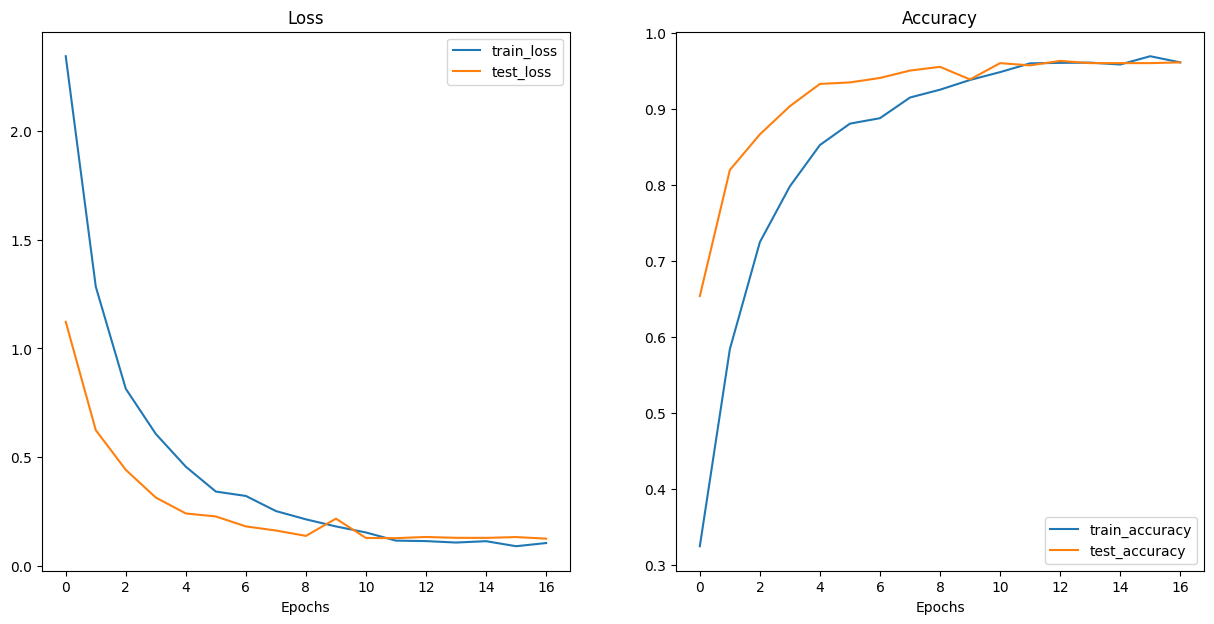

In [33]:
plot_loss_curves(model_1_results)

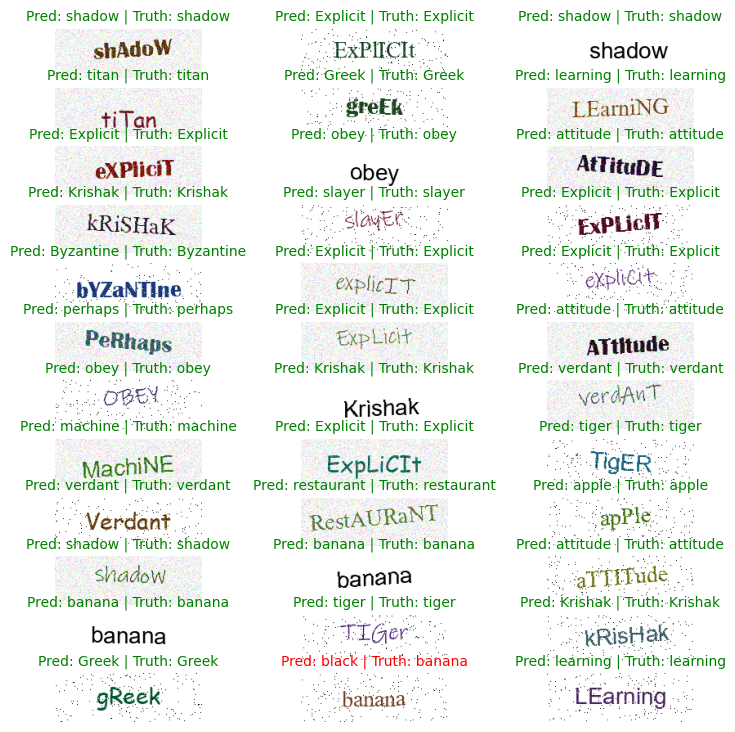

In [35]:
test_random_samples(model_1, True, True)

## Significance of Easy Dataset

Before I finally obtain the final Model for Task 1 (having 100 classes), I first want to gauge how useful the easy data set really is. ```model_2``` shall be trained only on the hard data set yet tested on the combined set.

In [36]:
model_2 = Classifier(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=16,
                  output_shape=20).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)
start_time = timer()

# Train model_2 on hard set only
model_2_results = train(model=model_2,
                        train_dataloader=hard_train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=13)

optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.0001)

model_2_fine_results = train(model=model_2,
                        train_dataloader=hard_train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=7)

for key in model_2_results:
  model_2_results[key] += model_2_fine_results[key]

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9996 | train_acc: 0.0478 | test_loss: 2.9984 | test_acc: 0.0488
Epoch: 2 | train_loss: 2.9969 | train_acc: 0.0488 | test_loss: 2.9980 | test_acc: 0.0488
Epoch: 3 | train_loss: 2.9968 | train_acc: 0.0425 | test_loss: 2.9976 | test_acc: 0.0488
Epoch: 4 | train_loss: 2.9966 | train_acc: 0.0462 | test_loss: 2.9973 | test_acc: 0.0488
Epoch: 5 | train_loss: 2.9965 | train_acc: 0.0481 | test_loss: 2.9970 | test_acc: 0.0488
Epoch: 6 | train_loss: 2.9962 | train_acc: 0.0409 | test_loss: 2.9969 | test_acc: 0.0488
Epoch: 7 | train_loss: 2.9965 | train_acc: 0.0497 | test_loss: 2.9965 | test_acc: 0.0488
Epoch: 8 | train_loss: 2.9963 | train_acc: 0.0419 | test_loss: 2.9965 | test_acc: 0.0488
Epoch: 9 | train_loss: 2.9963 | train_acc: 0.0444 | test_loss: 2.9965 | test_acc: 0.0459
Epoch: 10 | train_loss: 2.9962 | train_acc: 0.0425 | test_loss: 2.9963 | test_acc: 0.0488
Epoch: 11 | train_loss: 2.9961 | train_acc: 0.0447 | test_loss: 2.9961 | test_acc: 0.0488
Epoch: 12 | train_l

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9957 | train_acc: 0.0478 | test_loss: 2.9961 | test_acc: 0.0488
Epoch: 2 | train_loss: 2.9960 | train_acc: 0.0472 | test_loss: 2.9960 | test_acc: 0.0488
Epoch: 3 | train_loss: 2.9957 | train_acc: 0.0559 | test_loss: 2.9960 | test_acc: 0.0488
Epoch: 4 | train_loss: 2.9958 | train_acc: 0.0541 | test_loss: 2.9960 | test_acc: 0.0488
Epoch: 5 | train_loss: 2.9960 | train_acc: 0.0478 | test_loss: 2.9960 | test_acc: 0.0488
Epoch: 6 | train_loss: 2.9958 | train_acc: 0.0497 | test_loss: 2.9960 | test_acc: 0.0488
Epoch: 7 | train_loss: 2.9960 | train_acc: 0.0466 | test_loss: 2.9960 | test_acc: 0.0488
Total training time: 39.363 seconds


The accuracy never rose beyond 5%! (which is equivalent to random performance given there are 20 classes). I run this code several times and most times I received a similar result with the loss value no longer improving from optimization. In some runs the loss value did improve but the accuracy capped out at 80%, much less than what the architecture is capable of achieving.

It looks like the easy set was quite useful after all. It helps establish strong base rules for the model to follow (the samples in the easy set are much more firm images of their respective class). After training on the easy set, the hard set can be used to better generalize the model to be able to classify more diverse samples.
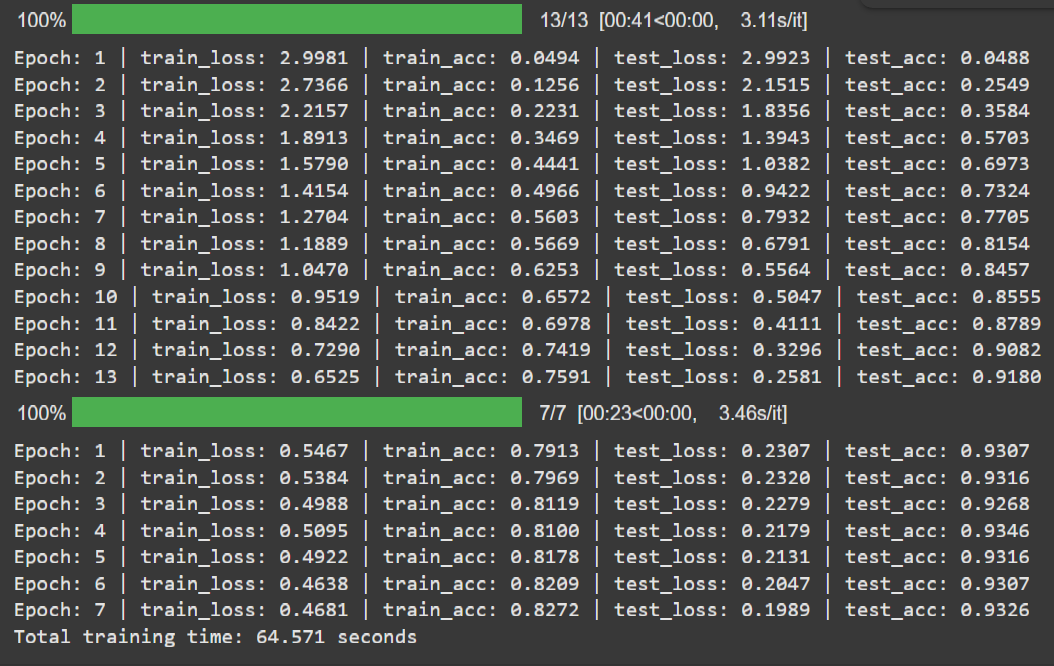

Above is a screenshot of one of the instances of training a new model solely on the hard set. The model clearly wasn't able to improve as steadily and exhibited stunted growth during training (The 3 extra epochs are to compensate for not training on the easy set).

In one of the instances, the model accuracy (train and test) stopped improving beyond ~50% after the initial few epochs. This was the most interesting observation yet which could possibly mean that in the absence of a strong foundation (gained from training on the easy set first), the training might reach a dead end where further backpropagation and optimization no longer improve the score.

Perhaps, a local minima was acheived during gradient descent: one that is quite far off from the global minima the Classifier can potentially achieve (which has accuracy of around 97% and loss value ~0.1).

# Experiment - 1.2

Finally, let me try generating and training a model to classify a dataset with 100 classes.

I will use the same TinyVGG (VGG) inspired Classifier as earlier but now I can potentially make changes to the following hyperparameters:

1.   Number of hidden units per layer: Till now I have used hidden_units = 16 i.e. a structure of 16->32->64->128 filters/units per layer internally.
2.   Output shape: needs to be 100 for 100 classes.
3.   Number of epochs to train for.
4.   Number of samples per class in the dataset: In order to keep the training time reasonable with a hundred classes (enough to allow me to do repeated testing), I would ideally want to decrease the number of samples per class so as to keep the size of the whole dataset reasonable. But doing so could catastrophically affect the generalization ability of the model especially with increased number of classes.

Whilst looking for a solution to this problem I stumbled upon the technique called ***on-the-fly data augmentation***. Instead of augmenting the data during dataset generation, I can instead augment the data (rotation, shifting, scaling) whilst training by incorporating my data augmentation function into the data-loading pipeline.
Thus a single image can be augmented multiple times whilst training (a slightly different version of the image in each epoch).

Let me set up the augmentation:


In [ ]:
class RandomAugmentation:
    def __call__(self, image):
        return apply_augmentation(image)

train_transform = transforms.Compose([
    RandomAugmentation(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])


# modify the create_datasets function so as to be able to reuse the previous model training pipeline.
def create_datasets():
    global easy_train_data, easy_test_data, hard_train_data, hard_test_data, class_names, combined_train_data, combined_test_data

    # Apply the same augmentation for easy and hard training datasets
    easy_train_data = datasets.ImageFolder(root=easy_train_dir, transform=train_transform)
    hard_train_data = datasets.ImageFolder(root=hard_train_dir, transform=train_transform)

    # DOn't need augmentation for test datasets, but might as well do it.
    easy_test_data = datasets.ImageFolder(root=easy_test_dir, transform=train_transform)
    hard_test_data = datasets.ImageFolder(root=hard_test_dir, transform=train_transform)

    class_names = easy_train_data.classes

    combined_train_data = ConcatDataset([easy_train_data, hard_train_data])
    combined_test_data = ConcatDataset([easy_test_data, hard_test_data])


Now to generate the dataset:

  A Brief Calculation:
  Previously the dataset had `(50 + 200) * 20 = 5000` images total.

  With `100` classes and a limit of `5000 * 2 = 10000` images total, I would want around `10000/100 = 100` images per class.
  
  Since augmentation has now been introduced into the training pipeline, the easy dataset can be collapsed tremendously. Thus I propose (use) an initial split of `(5,95)` images `(easy,hard)` per class. (subject to change)


In [1]:

WORDS = [
    "apple", "banana", "slayer", "perhaps", "restaurant", "tiger", "verdant", "machine", "titan", "shadow",
    "learning", "Gaming", "Explicit", "Krishak", "Byzantine", "Greek", "obey", "attitude", "yellow", "black",
    "ocean", "forest", "cyber", "dusk", "dawn", "spirit", "logic", "energy", "fusion", "vector",
    "omega", "pixel", "quantum", "neon", "vortex", "glitch", "matrix", "Diamond", "Azure", "Sapphire",
    "Emerald", "Ruby", "Topaz", "Aventurine", "golden", "copper", "iron", "steel", "whisper", "echo",
    "raven", "phoenix", "eclipse", "meteor", "zenith", "spectrum", "vivid", "luminous", "cosmic", "orbital",
    "gravity", "vital", "ignite", "spark", "flame", "ember", "blaze", "inferno", "horizon", "vista",
    "mirage", "solstice", "equinox", "cascade", "tide", "tempest", "breeze", "gale", "zephyr", "whirlwind",
    "cyclone", "storm", "thunder", "lightning", "drizzle", "monsoon", "frost", "glacier", "tundra", "meadow",
    "Aanan", "Kavin", "Akshat", "Divit", "Leeyun", "Ziggy", "Isabella", "Mia", "Elijah", "Olivia"
]

total_len = 0
for word in WORDS:
    total_len += len(word)
count = len(WORDS)
avg_len = total_len / count

print(f"Count: {count}\nAvg word length: {avg_len}\nExpected number of capitalization configurations: {pow(2, avg_len)}")

# generate_dataset(5, 95, False)

Count: 100
Avg word length: 6.07
Expected number of capitalization configurations: 67.18186775187633


Besides the dataset size, there are some more considerations I made that makes 95 a good fit for the number of hard samples per class.

The choice of `5` fonts, `~10` colors (rough number of distinct colors required per class) and `2` types of noise, also points towards having `5 * 10 * 2 = ~100` samples per class.

Further, the mean word length of `6.07` means that there exist an estimate `67` configurations of capitalization for each class. `95` should cover most if not all of the capitalizations the word can have.

Combined with the shifts,rotations and scaling applied to the images on-the-fly, this leads to a truly robust dataset that the model should be able to generalize well on. 

In [44]:
walk_through_dir(OUTPUT_DIR)

There are 2 directories and 0 images in '/kaggle/working/fontset/data'.
There are 2 directories and 0 images in '/kaggle/working/fontset/data/hard'.
There are 100 directories and 0 images in '/kaggle/working/fontset/data/hard/train'.
There are 0 directories and 76 images in '/kaggle/working/fontset/data/hard/train/Kavin'.
There are 0 directories and 76 images in '/kaggle/working/fontset/data/hard/train/glitch'.
There are 0 directories and 76 images in '/kaggle/working/fontset/data/hard/train/eclipse'.
There are 0 directories and 76 images in '/kaggle/working/fontset/data/hard/train/orbital'.
There are 0 directories and 76 images in '/kaggle/working/fontset/data/hard/train/flame'.
There are 0 directories and 76 images in '/kaggle/working/fontset/data/hard/train/vivid'.
There are 0 directories and 76 images in '/kaggle/working/fontset/data/hard/train/forest'.
There are 0 directories and 76 images in '/kaggle/working/fontset/data/hard/train/drizzle'.
There are 0 directories and 76 images 

Time to train!!!
Before I start training on the hard set, I shall train the model to classify the easy set correctly.
(Number of epochs to run: 69 -> 10, was what I chose after a few rounds of testing to be the best)

In [45]:
create_datasets()

create_dataloader()

random.seed(69)
torch.manual_seed(69)
torch.cuda.manual_seed(69)

# Recreate an instance of the model
model_3 = Classifier(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=16,
                  output_shape=100).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_3 on easy set
model_3_results = train(model=model_3,
                        train_dataloader=easy_train_dataloader,
                        test_dataloader=easy_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=69)

optimizer = torch.optim.Adam(params=model_3.parameters(), lr=0.0001)

model_3_results = train(model=model_3,
                        train_dataloader=easy_train_dataloader,
                        test_dataloader=easy_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


Easy Train dataloader:
Easy Test dataloader:
Hard Train dataloader:
Hard Test dataloader:
Train dataloader:
Test dataloader:


  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6262 | train_acc: 0.0168 | test_loss: 4.6020 | test_acc: 0.0078
Epoch: 2 | train_loss: 4.6065 | train_acc: 0.0072 | test_loss: 4.6011 | test_acc: 0.0078
Epoch: 3 | train_loss: 4.6040 | train_acc: 0.0072 | test_loss: 4.5941 | test_acc: 0.0078
Epoch: 4 | train_loss: 4.5985 | train_acc: 0.0096 | test_loss: 4.5835 | test_acc: 0.0781
Epoch: 5 | train_loss: 4.5492 | train_acc: 0.0337 | test_loss: 4.4870 | test_acc: 0.0781
Epoch: 6 | train_loss: 4.4927 | train_acc: 0.0144 | test_loss: 4.4220 | test_acc: 0.0234
Epoch: 7 | train_loss: 4.3464 | train_acc: 0.0168 | test_loss: 4.2884 | test_acc: 0.0625
Epoch: 8 | train_loss: 4.2382 | train_acc: 0.0288 | test_loss: 4.0697 | test_acc: 0.0312
Epoch: 9 | train_loss: 4.1544 | train_acc: 0.0409 | test_loss: 4.0672 | test_acc: 0.0547
Epoch: 10 | train_loss: 4.0435 | train_acc: 0.0409 | test_loss: 3.8190 | test_acc: 0.1250
Epoch: 11 | train_loss: 3.8883 | train_acc: 0.0577 | test_loss: 3.7494 | test_acc: 0.0703
Epoch: 12 | train_l

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7143 | train_acc: 0.7596 | test_loss: 0.0731 | test_acc: 0.9922
Epoch: 2 | train_loss: 0.7621 | train_acc: 0.7452 | test_loss: 0.0551 | test_acc: 0.9844
Epoch: 3 | train_loss: 0.6444 | train_acc: 0.7885 | test_loss: 0.0462 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.7112 | train_acc: 0.7548 | test_loss: 0.0751 | test_acc: 0.9922
Epoch: 5 | train_loss: 0.6332 | train_acc: 0.7957 | test_loss: 0.0393 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.7096 | train_acc: 0.7548 | test_loss: 0.0786 | test_acc: 0.9922
Epoch: 7 | train_loss: 0.7091 | train_acc: 0.7740 | test_loss: 0.0597 | test_acc: 0.9922
Epoch: 8 | train_loss: 0.6807 | train_acc: 0.7596 | test_loss: 0.0428 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.7226 | train_acc: 0.7596 | test_loss: 0.0646 | test_acc: 0.9922
Epoch: 10 | train_loss: 0.6506 | train_acc: 0.7788 | test_loss: 0.0389 | test_acc: 1.0000
Total training time: 46.187 seconds


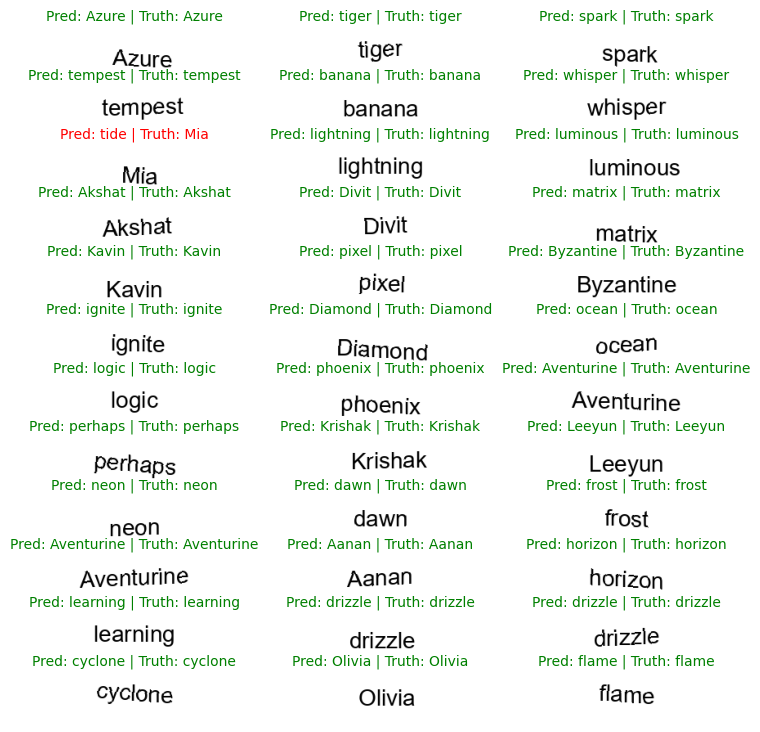

In [49]:
test_random_samples(model_3,
                    False,
                    test= False)

That worked out better than I expected. I didn't expect the initial Classifier to be viable even for 100 classes.
The fact that the test accuracy reached 100% and exceeded training accuracy (capped at 80%), certainly perplexes me. But it could be because the easy test set currently only consists of a single image in each class with minimal augmentation. 
The model currently underfits on the training data and I try the following approaches to fix that:

- Increasing the number of hidden_units.
- Adding another layer of convolution
- Adding another fully connected layer before the output layer. (Currently only 1 layer of hidden_units * 8 neurons)
- A combination of the above approaches.

After testing all of these out, the first (and simplest) approach seemed to work best. Adding more convolutional/classification layers actually seemed to sabotage the model and make it completely incapable of the task.

Increasing the number of hidden_units also presented some challenge and in my experiments, 24 is the sweet spot. In particular I tried the numbers 16, 24, 32 and several non-multiples of 8 in (16,32). For all but 24, the train_loss had a limiting value of 4.605.


In [56]:
# Recreate an instance of the model

hidden_units = 24

model_4 = Classifier(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=hidden_units,
                  output_shape=100).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_3 on easy set
model_4_results = train(model=model_4,
                        train_dataloader=easy_train_dataloader,
                        test_dataloader=easy_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=69)

optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.0001)

model_4_results = train(model=model_4,
                        train_dataloader=easy_train_dataloader,
                        test_dataloader=easy_test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/69 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6192 | train_acc: 0.0120 | test_loss: 4.6038 | test_acc: 0.0000
Epoch: 2 | train_loss: 4.6068 | train_acc: 0.0096 | test_loss: 4.6040 | test_acc: 0.0078
Epoch: 3 | train_loss: 4.6098 | train_acc: 0.0096 | test_loss: 4.6042 | test_acc: 0.0078
Epoch: 4 | train_loss: 4.6071 | train_acc: 0.0120 | test_loss: 4.6040 | test_acc: 0.0078
Epoch: 5 | train_loss: 4.6062 | train_acc: 0.0120 | test_loss: 4.6041 | test_acc: 0.0078
Epoch: 6 | train_loss: 4.6066 | train_acc: 0.0120 | test_loss: 4.6039 | test_acc: 0.0078
Epoch: 7 | train_loss: 4.6066 | train_acc: 0.0048 | test_loss: 4.6038 | test_acc: 0.0078
Epoch: 8 | train_loss: 4.6061 | train_acc: 0.0144 | test_loss: 4.6037 | test_acc: 0.0156
Epoch: 9 | train_loss: 4.6052 | train_acc: 0.0120 | test_loss: 4.6033 | test_acc: 0.0078
Epoch: 10 | train_loss: 4.6060 | train_acc: 0.0096 | test_loss: 4.6038 | test_acc: 0.0078
Epoch: 11 | train_loss: 4.6059 | train_acc: 0.0096 | test_loss: 4.6039 | test_acc: 0.0078
Epoch: 12 | train_l

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2893 | train_acc: 0.9038 | test_loss: 0.0071 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.3238 | train_acc: 0.8966 | test_loss: 0.0095 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.2269 | train_acc: 0.9135 | test_loss: 0.0059 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.2793 | train_acc: 0.8990 | test_loss: 0.0154 | test_acc: 0.9922
Epoch: 5 | train_loss: 0.2533 | train_acc: 0.9279 | test_loss: 0.0234 | test_acc: 0.9922
Epoch: 6 | train_loss: 0.2348 | train_acc: 0.9207 | test_loss: 0.0068 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.2070 | train_acc: 0.9111 | test_loss: 0.0055 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.2348 | train_acc: 0.9159 | test_loss: 0.0093 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.2087 | train_acc: 0.9279 | test_loss: 0.0065 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.2127 | train_acc: 0.9255 | test_loss: 0.0038 | test_acc: 1.0000
Total training time: 54.140 seconds


In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.001)
start_time = timer()

# Train model_4 on hard set
model_4_results = train(model=model_4,
                        train_dataloader=hard_train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=20)

optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.0001)

model_4_fine_results = train(model=model_4,
                        train_dataloader=hard_train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=10)

for key in model_4_results:
  model_4_results[key] += model_4_fine_results[key]

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3079 | train_acc: 0.2166 | test_loss: 1.8021 | test_acc: 0.5382
Epoch: 2 | train_loss: 2.0880 | train_acc: 0.4304 | test_loss: 1.0636 | test_acc: 0.7227
Epoch: 3 | train_loss: 1.4928 | train_acc: 0.5718 | test_loss: 0.7132 | test_acc: 0.8189
Epoch: 4 | train_loss: 1.1427 | train_acc: 0.6650 | test_loss: 0.4714 | test_acc: 0.8695
Epoch: 5 | train_loss: 0.9623 | train_acc: 0.7135 | test_loss: 0.3945 | test_acc: 0.9053
Epoch: 6 | train_loss: 0.8007 | train_acc: 0.7600 | test_loss: 0.2999 | test_acc: 0.9301
Epoch: 7 | train_loss: 0.6650 | train_acc: 0.7921 | test_loss: 0.2103 | test_acc: 0.9474
Epoch: 8 | train_loss: 0.5703 | train_acc: 0.8227 | test_loss: 0.1770 | test_acc: 0.9539
Epoch: 9 | train_loss: 0.4987 | train_acc: 0.8445 | test_loss: 0.1350 | test_acc: 0.9628
Epoch: 10 | train_loss: 0.4530 | train_acc: 0.8577 | test_loss: 0.1271 | test_acc: 0.9668
Epoch: 11 | train_loss: 0.3855 | train_acc: 0.8751 | test_loss: 0.0881 | test_acc: 0.9727
Epoch: 12 | train_l

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1422 | train_acc: 0.9542 | test_loss: 0.0194 | test_acc: 0.9945
Epoch: 2 | train_loss: 0.1443 | train_acc: 0.9560 | test_loss: 0.0163 | test_acc: 0.9945
Epoch: 3 | train_loss: 0.1202 | train_acc: 0.9613 | test_loss: 0.0162 | test_acc: 0.9965
Epoch: 4 | train_loss: 0.1203 | train_acc: 0.9624 | test_loss: 0.0179 | test_acc: 0.9955
Epoch: 5 | train_loss: 0.1300 | train_acc: 0.9565 | test_loss: 0.0140 | test_acc: 0.9975
Epoch: 6 | train_loss: 0.1157 | train_acc: 0.9622 | test_loss: 0.0143 | test_acc: 0.9965
Epoch: 7 | train_loss: 0.1149 | train_acc: 0.9644 | test_loss: 0.0119 | test_acc: 0.9965
Epoch: 8 | train_loss: 0.1058 | train_acc: 0.9652 | test_loss: 0.0194 | test_acc: 0.9950
Epoch: 9 | train_loss: 0.1016 | train_acc: 0.9670 | test_loss: 0.0121 | test_acc: 0.9965
Epoch: 10 | train_loss: 0.1013 | train_acc: 0.9694 | test_loss: 0.0137 | test_acc: 0.9960
Total training time: 183.695 seconds


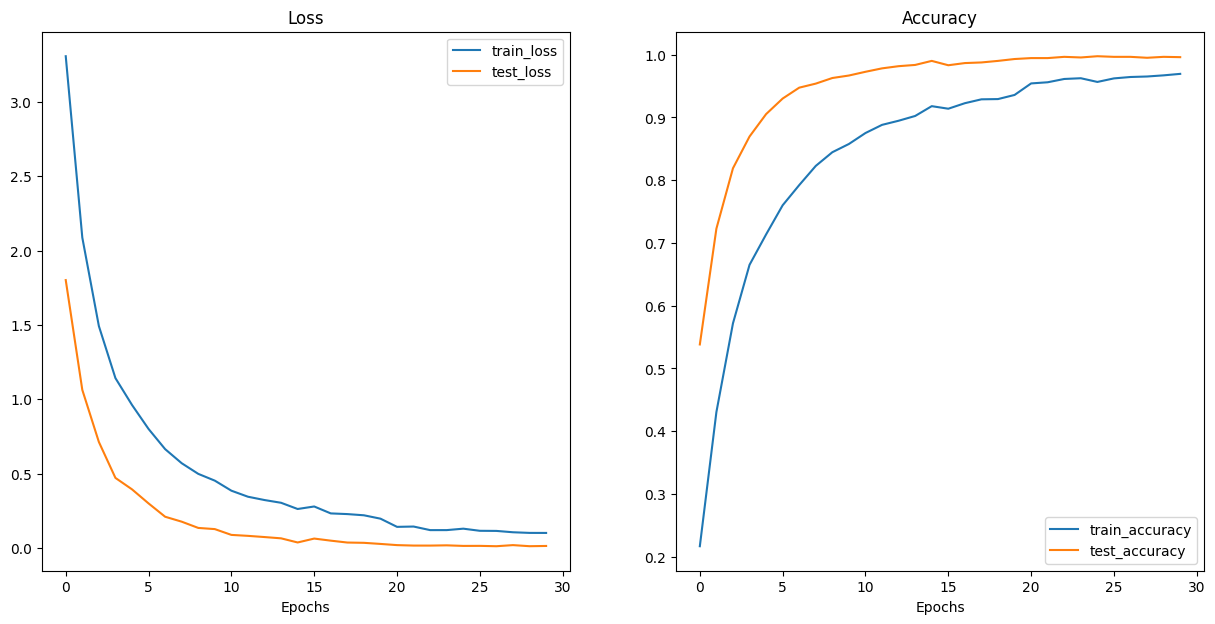

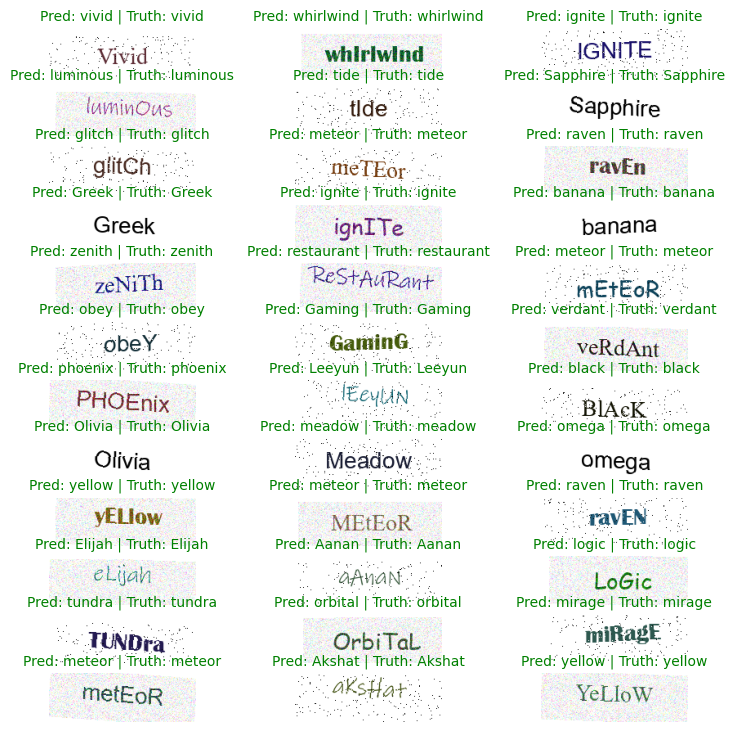

In [59]:
plot_loss_curves(model_4_results)
test_random_samples(model_4, True, True)

In [60]:
# Saving the model and dataset

shutil.make_archive("captcha_data", 'zip', OUTPUT_DIR)

# Define save path
model_save_path = "/kaggle/working/classifier.pth"

# Save the trained model
torch.save(model_4.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/classifier.pth


The following code trains another model (model_5) on the combined dataset instead of first training on the easy set followed by the hard set. As expected earlier, it doesn't work.

In [61]:
# Recreate an instance of the model
model_5 = Classifier(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=24,
                  output_shape=100).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_5.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_4 on combined set
model_5_results = train(model=model_5,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=15)

optimizer = torch.optim.Adam(params=model_5.parameters(), lr=0.0001)

model_5_fine_results = train(model=model_5,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=5)

for key in model_5_results:
  model_5_results[key] += model_5_fine_results[key]

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6081 | train_acc: 0.0089 | test_loss: 4.6055 | test_acc: 0.0099
Epoch: 2 | train_loss: 4.6065 | train_acc: 0.0074 | test_loss: 4.6054 | test_acc: 0.0099
Epoch: 3 | train_loss: 4.6064 | train_acc: 0.0073 | test_loss: 4.6053 | test_acc: 0.0099
Epoch: 4 | train_loss: 4.6063 | train_acc: 0.0075 | test_loss: 4.6053 | test_acc: 0.0099
Epoch: 5 | train_loss: 4.6062 | train_acc: 0.0095 | test_loss: 4.6052 | test_acc: 0.0099
Epoch: 6 | train_loss: 4.6062 | train_acc: 0.0081 | test_loss: 4.6052 | test_acc: 0.0099
Epoch: 7 | train_loss: 4.6061 | train_acc: 0.0081 | test_loss: 4.6052 | test_acc: 0.0099
Epoch: 8 | train_loss: 4.6061 | train_acc: 0.0086 | test_loss: 4.6051 | test_acc: 0.0099
Epoch: 9 | train_loss: 4.6060 | train_acc: 0.0086 | test_loss: 4.6051 | test_acc: 0.0099
Epoch: 10 | train_loss: 4.6060 | train_acc: 0.0077 | test_loss: 4.6051 | test_acc: 0.0099
Epoch: 11 | train_loss: 4.6060 | train_acc: 0.0080 | test_loss: 4.6052 | test_acc: 0.0099
Epoch: 12 | train_l

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6053 | train_acc: 0.0100 | test_loss: 4.6052 | test_acc: 0.0099
Epoch: 2 | train_loss: 4.6053 | train_acc: 0.0100 | test_loss: 4.6051 | test_acc: 0.0099
Epoch: 3 | train_loss: 4.6053 | train_acc: 0.0100 | test_loss: 4.6052 | test_acc: 0.0099
Epoch: 4 | train_loss: 4.6053 | train_acc: 0.0100 | test_loss: 4.6051 | test_acc: 0.0099
Epoch: 5 | train_loss: 4.6053 | train_acc: 0.0100 | test_loss: 4.6051 | test_acc: 0.0099
Total training time: 126.279 seconds


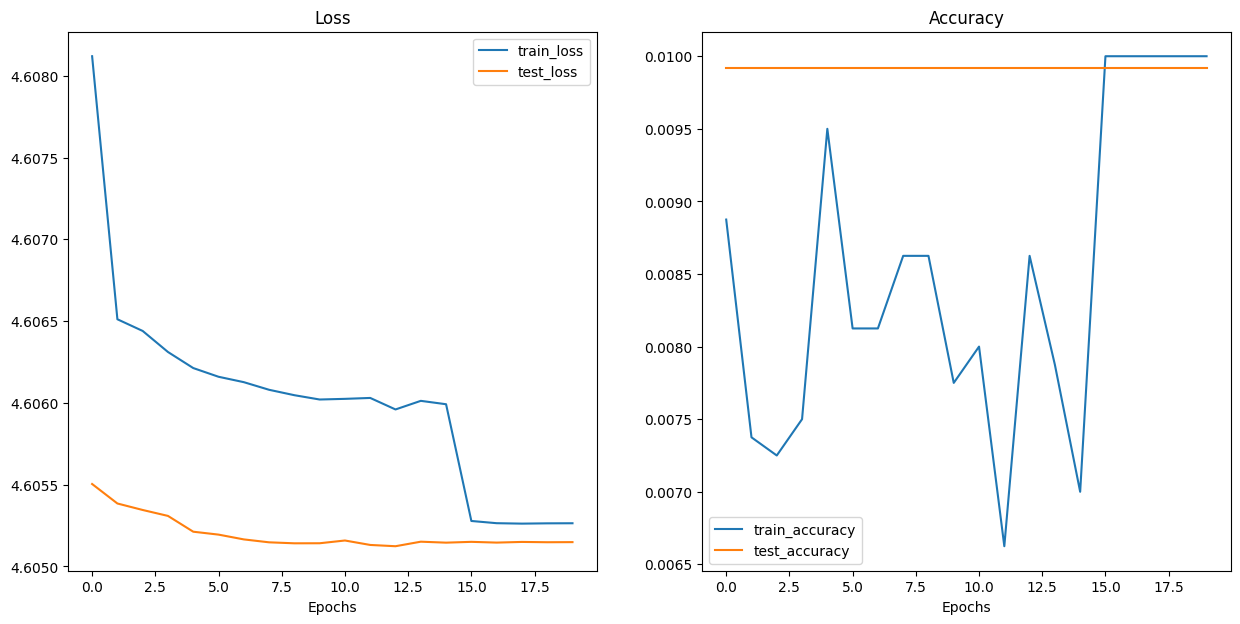

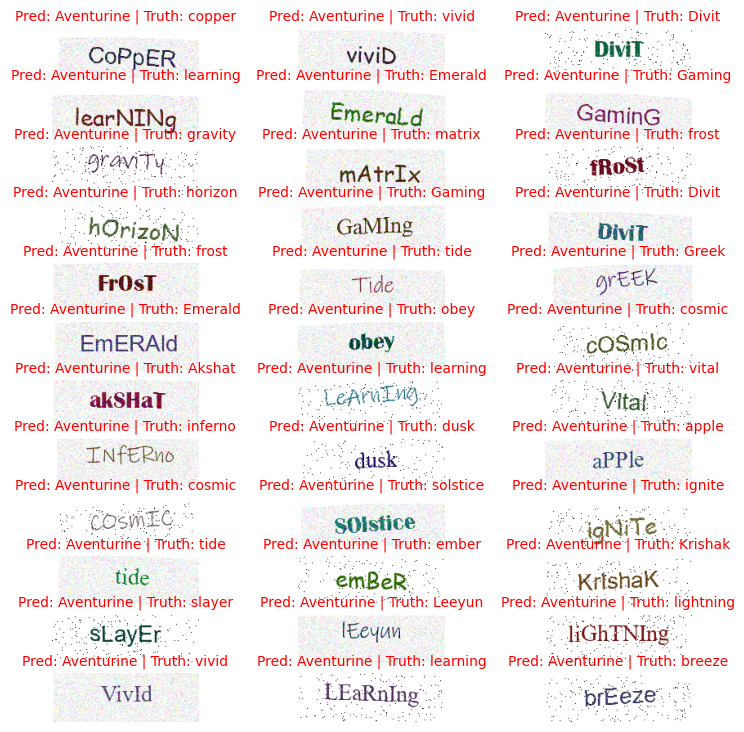

In [62]:
plot_loss_curves(model_5_results)
test_random_samples(model_5, True, True)

# Conclusion

That's the end of the first Experiment. We've successfully obtained a neural classifier (model_4) that classifies captchas belonging to one of 100 classes with an accuracy of ~99.6% on the test set.

